This notebooks shows how to derive transfer functions for analysis of longitudinal aircraft dynamics.

# Translational Equations of Motion

$\frac{^ed}{dt} m V = F$

Mechanized in inertial frame:
$\frac{^ed}{dt} m V_e = F_e$

$\frac{^ed}{dt} m V_e = F_e$

If m is constants, back to F= mA

$m \dot{V_e} = F_e$

$m A_e = F_e$


Mechanized in body frame:
$\frac{^bd}{dt} m V_b + \omega^{eb}_b \times (m V_b) = F_b$

If taking derivative of a vector with respect to frame it is expressed in, 
it becomes the vector dot, time derivative of components.

$m \dot{V_b} + \omega^{eb}_b \times (m V_b) = F_b$


# Rotational Equations of Motion

$\frac{^ed}{dt} J \omega^{eb} = M$

$\frac{^bd}{dt} J \omega^{eb}_b + \omega^{eb}_b \times J \omega^{eb}_b  = M_b$

If J is constant (rotational inertial in body frame about cm):

$J \dot{\omega^{eb}_b} + \omega^{eb}_b \times J \omega^{eb}_b  = M_b$


In [1]:
import sympy
import sympy.physics.mechanics as me
import scipy.optimize
import scipy.integrate
import matplotlib.pyplot as plt
import control
import numpy as np

m, J_y, g, t = sympy.symbols('m, J_y, g, t')
gamma, alpha, V, Q = me.dynamicsymbols('gamma, alpha, V, Q') # functions of time
frame_e = me.ReferenceFrame('e')
frame_w = frame_e.orientnew('w', 'Axis', (gamma, frame_e.y))
frame_b = frame_w.orientnew('b', 'Axis', (-alpha, frame_w.y))
J = me.inertia(frame_b, 0, J_y, 0)

# control inputs
th, elv = sympy.symbols('th, elv')  # thrust, elevator

T = th 

# gravitational force
W = m*g

## Aerodynamics Model

In [2]:
C_La, C_L0, k_CLCD, C_D0, C_M0, C_Me, C_MQ, C_Ma, rho, S, alpha_s = \
    sympy.symbols('C_La, C_L0, k_CLCD, C_D0, C_M0, C_Me, C_MQ, C_Ma, rho, S, alpha_s')

# aero coefficients, neglecting stall
C_L = C_L0 + C_La*alpha
C_D = C_D0 + k_CLCD*C_L**2
C_M = C_M0 + C_Ma*alpha + C_Me*elv + C_MQ*Q

# aero forces/moments
q = rho*V**2/2
D = C_D*q*S
L = C_L*q*S
M = C_M*q*S

In [3]:
C_L

C_L0 + C_La*alpha(t)

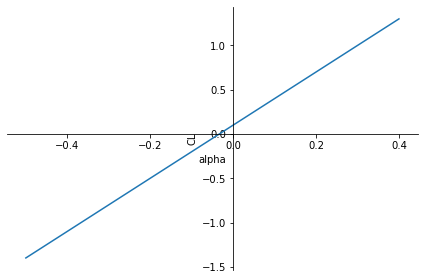

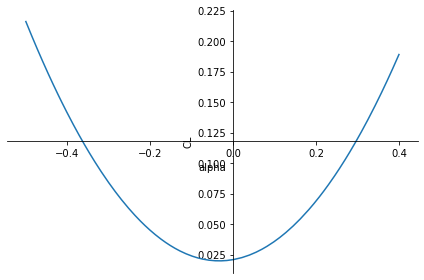

In [4]:
alpha_var = sympy.symbols('alpha')
sympy.plot(C_L.subs({C_L0: 0.1, C_La: 3, alpha: alpha_var}),
           (alpha_var, -0.5, 0.4),
           xlabel='alpha',
           ylabel='CL')
sympy.plot(C_D.subs({C_D0: 0.02, k_CLCD: 0.1, C_L0: 0.1, C_La: 3, alpha: alpha_var}),
           (alpha_var, -0.5, 0.4),
           xlabel='alpha',
           ylabel='CL')

# Dynamics

Sum of forces.

In [6]:
F_b = (-L*frame_w.z - D*frame_w.x + W*frame_e.z + T*frame_b.x).express(frame_b).simplify()
F_b

(-S*rho*(C_D0 + k_CLCD*(C_L0 + C_La*alpha(t))**2)*V(t)**2*cos(alpha(t))/2 - S*rho*(C_L0 + C_La*alpha(t))*V(t)**2*sin(alpha(t))/2 + g*m*sin(alpha(t) - gamma(t)) + th)*b.x + (S*rho*(C_D0 + k_CLCD*(C_L0 + C_La*alpha(t))**2)*V(t)**2*sin(alpha(t))/2 - S*rho*(C_L0 + C_La*alpha(t))*V(t)**2*cos(alpha(t))/2 + g*m*cos(alpha(t) - gamma(t)))*b.z

In [7]:
F_w = (-L*frame_w.z - D*frame_w.x + W*frame_e.z + T*frame_b.x).express(frame_w).simplify()
F_w

(-S*rho*(C_D0 + k_CLCD*(C_L0 + C_La*alpha(t))**2)*V(t)**2/2 - g*m*sin(gamma(t)) + th*cos(alpha(t)))*w.x + (-S*rho*(C_L0 + C_La*alpha(t))*V(t)**2/2 + g*m*cos(gamma(t)) + th*sin(alpha(t)))*w.z

Find linear momentum take derivative in earth frame (Newton-Euler EOMs)

In [8]:
LM = m*V*frame_w.x
eom_trans = LM.diff(t, frame_e).simplify() - F_w
eom_trans = eom_trans.to_matrix(frame_w)
eom_trans

Matrix([
[S*rho*(C_D0 + k_CLCD*(C_L0 + C_La*alpha(t))**2)*V(t)**2/2 + g*m*sin(gamma(t)) + m*Derivative(V(t), t) - th*cos(alpha(t))],
[                                                                                                                       0],
[          S*rho*(C_L0 + C_La*alpha(t))*V(t)**2/2 - g*m*cos(gamma(t)) - m*V(t)*Derivative(gamma(t), t) - th*sin(alpha(t))]])

Sum of moments.

In [9]:
M_b = (M*frame_b.y).express(frame_w).simplify()
M_b

S*rho*(C_M0 + C_MQ*Q(t) + C_Ma*alpha(t) + C_Me*elv)*V(t)**2/2*w.y

Finding angular momentum, take derivative in earth frame (Newton-Euler EOms)

In [10]:
AM = J_y*frame_b.ang_vel_in(frame_e).express(frame_w).subs(gamma.diff(t) - alpha.diff(t), Q)
AM

J_y*Q(t)*w.y

# Equations of Motion

In [11]:
eom_rot = (AM.diff(t, frame_e) - M_b).to_matrix(frame_b)
eom_rot

Matrix([
[                                                                                      0],
[J_y*Derivative(Q(t), t) - S*rho*(C_M0 + C_MQ*Q(t) + C_Ma*alpha(t) + C_Me*elv)*V(t)**2/2],
[                                                                                      0]])

Create first order ODE model.

$\dot{x} = f(x, u, p)$

x: states
u: inputs
p: parameters

$\gamma = \theta - \alpha$

$\dot{\gamma} = \dot{\theta} - \dot{\alpha}$

$\dot{\theta} \equiv Q$

$Q = \dot{\gamma} + \dot{\alpha}$

In [12]:
eoms = sympy.Matrix.vstack(eom_trans, eom_rot)
eoms = sympy.Matrix([
    eom_rot[1],
    eom_trans[0],
    eom_trans[2],
    gamma.diff(t) + alpha.diff(t) - Q
])
eoms

Matrix([
[                                 J_y*Derivative(Q(t), t) - S*rho*(C_M0 + C_MQ*Q(t) + C_Ma*alpha(t) + C_Me*elv)*V(t)**2/2],
[S*rho*(C_D0 + k_CLCD*(C_L0 + C_La*alpha(t))**2)*V(t)**2/2 + g*m*sin(gamma(t)) + m*Derivative(V(t), t) - th*cos(alpha(t))],
[          S*rho*(C_L0 + C_La*alpha(t))*V(t)**2/2 - g*m*cos(gamma(t)) - m*V(t)*Derivative(gamma(t), t) - th*sin(alpha(t))],
[                                                               -Q(t) + Derivative(alpha(t), t) + Derivative(gamma(t), t)]])

In [13]:
x = sympy.Matrix([V, alpha, gamma, Q])
x.T

Matrix([[V(t), alpha(t), gamma(t), Q(t)]])

In [14]:
u = sympy.Matrix([th, elv])
u.T

Matrix([[th, elv]])

In [68]:
h_dot = V*sympy.sin(gamma)
y = sympy.Matrix([V, alpha, gamma, Q, h_dot])

In [16]:
dx = x.diff(t)
dx.T

Matrix([[Derivative(V(t), t), Derivative(alpha(t), t), Derivative(gamma(t), t), Derivative(Q(t), t)]])

In [17]:
sol = sympy.solve(eoms, dx)
f = sympy.Matrix([sol[dxi] for dxi in dx])
f.simplify()
f

Matrix([
[(-C_D0*S*rho*V(t)**2/2 - C_L0**2*S*k_CLCD*rho*V(t)**2/2 - C_L0*C_La*S*k_CLCD*rho*V(t)**2*alpha(t) - C_La**2*S*k_CLCD*rho*V(t)**2*alpha(t)**2/2 - g*m*sin(gamma(t)) + th*cos(alpha(t)))/m],
[                                                                                 (-S*rho*(C_L0 + C_La*alpha(t))*V(t)**2/2 + g*m*cos(gamma(t)) + m*Q(t)*V(t) + th*sin(alpha(t)))/(m*V(t))],
[                                                                                                (S*rho*(C_L0 + C_La*alpha(t))*V(t)**2/2 - g*m*cos(gamma(t)) - th*sin(alpha(t)))/(m*V(t))],
[                                                                                                                     S*rho*(C_M0 + C_MQ*Q(t) + C_Ma*alpha(t) + C_Me*elv)*V(t)**2/(2*J_y)]])

### Solve Initial Value Problem to Simulate

In [18]:
params = {
    m: 1,
    J_y: 1,
    g: 9.8,
    C_La: 3,
    C_L0: 0.1,
    k_CLCD: 0.1,
    C_D0: 0.03,
    C_M0: 0.01,
    C_Me: 0.1,
    C_MQ: -0.1,
    C_Ma: -0.1, # negative to be stable
    rho: 1.225,
    S: 1,
}
p = sympy.Matrix(list(params.keys()))
p.T

Matrix([[m, J_y, g, C_La, C_L0, k_CLCD, C_D0, C_M0, C_Me, C_MQ, C_Ma, rho, S]])

In [22]:
p0 = [params[k] for k in params.keys()]
p0

[1, 1, 9.8, 3, 0.1, 0.1, 0.03, 0.01, 0.1, -0.1, -0.1, 1.225, 1]

In [23]:
f_eval = sympy.lambdify([[V, alpha, gamma, Q], [th, elv], p], f[:])
f_eval([1, 0, 0, 1], [1, 0], p0)

[0.9810125, 10.738750000000001, -9.738750000000001, -0.05512500000000001]

Make sure your numerical evaluation function is fast.

This function takes 3 arguments, x (states), u (input), p (parameters)

$\dot{x} = f(x, u, p)$

In [32]:
%%timeit -n 10000
f_eval([10, 0, 0, 0], [1, 0], p0)

8.49 µs ± 596 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


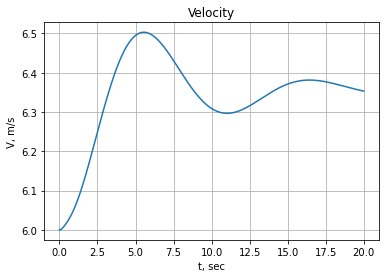

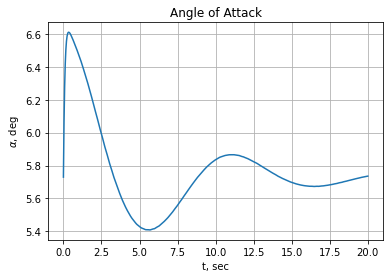

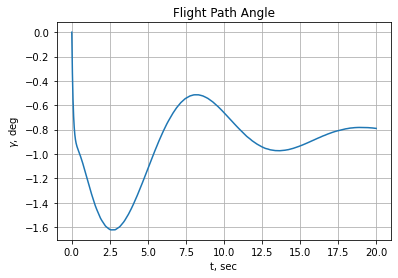

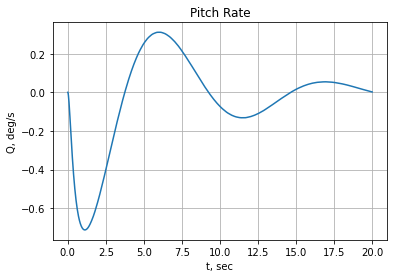

In [33]:
def simulate():
    t = np.linspace(0, 20, 1000)
    res = scipy.integrate.solve_ivp(
        fun=lambda t, x: f_eval(x, [1, 0], p0),
        t_span=[t[0], t[-1]], t_eval=t, y0=[6, 0.1, 0, 0])
    
    plt.figure()
    plt.plot(res.t, res.y.T[:, 0])
    plt.xlabel('t, sec')
    plt.ylabel('V, m/s')
    plt.grid()
    plt.title('Velocity');
    
    plt.figure()
    plt.plot(res.t, np.rad2deg(res.y.T[:, 1]))
    plt.xlabel('t, sec')
    plt.ylabel('$\\alpha$, deg')
    plt.grid()
    plt.title('Angle of Attack');
 
    plt.figure()
    plt.plot(res.t, np.rad2deg(res.y.T[:, 2]))
    plt.xlabel('t, sec')
    plt.ylabel('$\\gamma$, deg')
    plt.grid()
    plt.title('Flight Path Angle');
    
    plt.figure()
    plt.plot(res.t, np.rad2deg(res.y.T[:, 3]))
    plt.xlabel('t, sec')
    plt.ylabel('Q, deg/s')
    plt.grid()
    plt.title('Pitch Rate');
simulate()

# Aircraft Trim

Finding equilibrium $x_0$, $u_0$.

In [34]:
# trim cost, penalize state derivatives
trim_cost = sympy.Matrix([
    f[0]**2 + f[1]**2 + f[2]**2 + f[3]**2])

# calculate trim cost
trim_steady_level_obj = sympy.lambdify(
    [[alpha, th, elv], V, params.keys()],
    trim_cost.subs({
        gamma:0,
        Q: 0
    })[0])

# calculate trim cost jacobian
trim_steady_level_jac = sympy.lambdify(
    [[alpha, th, elv], V, params.keys()],
    trim_cost.subs({
        gamma:0,
        Q: 0
    }).jacobian([alpha, th, elv])[:])

In [46]:
def do_trim(V_0, p0):
    trim_res = scipy.optimize.minimize(
        fun=lambda x_d: trim_steady_level_obj(
            x_d, V_0, p0),
        # increases solver performance if you can
        # privde jacobian of the cost function, which
        # we can
        jac=lambda x_d: trim_steady_level_jac(
            x_d, V_0, p0),
        x0 = [0, 1, 0],
        tol=np.finfo(float).eps, bounds=[
            [-1, 1],  # alpha bounds, rad
            [0, 5],   # throttle bounds, N
            [-1, 1]], # elevator bounds, rad
        #method='Nelder-Mead'
    )
    print(trim_res)
    alpha_0, th_0, elv_0 = trim_res.x
    trim = {
        V: V_0,
        alpha: alpha_0,
        gamma: 0,
        Q: 0,
        th: th_0,
        elv: elv_0
    }
    return trim

trim = do_trim(V_0=10, p0=p0)
trim

      fun: 7.514775069826027e-25
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.01237904e-12, -1.04825328e-12, -6.94135125e-12])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 20
      nit: 15
     njev: 20
   status: 0
  success: True
        x: array([ 0.02021962,  1.99600204, -0.07978038])


{V(t): 10,
 alpha(t): 0.02021962262929675,
 gamma(t): 0,
 Q(t): 0,
 th: 1.9960020419541868,
 elv: -0.07978037737079575}

In [50]:
A = f.jacobian(x).subs(trim).subs(params)
A

Matrix([
[   -0.399118807992998, -5.94456905301602, -9.8,      0],
[   -0.196807113162693, -18.1754405960036,    0,      1],
[    0.196807113162693,  18.1754405960036,    0,      0],
[-1.13328183642958e-13,            -6.125,    0, -6.125]])

In [51]:
B = f.jacobian(u).subs(trim).subs(params)
B

Matrix([
[   0.999795590394625,     0],
[ 0.00202182449154941,     0],
[-0.00202182449154941,     0],
[                   0, 6.125]])

In [53]:
y.T

Matrix([[V(t), alpha(t), gamma(t), Q(t), V(t)*sin(gamma(t))]])

In [69]:
C = y.jacobian(x).subs(trim).subs(params)
C

Matrix([
[1, 0,  0, 0],
[0, 1,  0, 0],
[0, 0,  1, 0],
[0, 0,  0, 1],
[0, 0, 10, 0]])

In [70]:
D = y.jacobian(u).subs(trim).subs(params)
D

Matrix([
[0, 0],
[0, 0],
[0, 0],
[0, 0],
[0, 0]])

Now we can obtain the transfer function matrix relating all inputs to all outputs.

In [71]:
sys_aircraft = control.ss(A, B, C, D)
sys_aircraft

StateSpace(array([[-3.99118808e-01, -5.94456905e+00, -9.80000000e+00,
         0.00000000e+00],
       [-1.96807113e-01, -1.81754406e+01,  0.00000000e+00,
         1.00000000e+00],
       [ 1.96807113e-01,  1.81754406e+01,  0.00000000e+00,
         0.00000000e+00],
       [-1.13328184e-13, -6.12500000e+00,  0.00000000e+00,
        -6.12500000e+00]]), array([[ 9.99795590e-01,  0.00000000e+00],
       [ 2.02182449e-03,  0.00000000e+00],
       [-2.02182449e-03,  0.00000000e+00],
       [ 0.00000000e+00,  6.12500000e+00]]), array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0., 10.,  0.]]), array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]))

In [72]:
u.T

Matrix([[th, elv]])

In [73]:
y.T

Matrix([[V(t), alpha(t), gamma(t), Q(t), V(t)*sin(gamma(t))]])

In [74]:
G_aircraft = control.ss2tf(sys_aircraft)
G_aircraft

TransferFunction([[array([  0.99979559,  24.30326836, 117.47331023,   0.12136002]), array([ 1.01803188e-14, -3.64104854e+01, -1.09098082e+03])], [array([ 2.02182449e-03, -1.83576261e-01, -1.20025461e+00, -7.10542736e-15]), array([ 6.125     ,  2.4446027 , 11.81334697])], [array([-0.00202182,  0.18357626,  1.18787093,  1.20025461]), array([-3.15312118e-17,  1.11324574e+02,  3.72658886e+01])], [array([-2.21999217e-16, -1.23836750e-02,  1.20025461e+00,  3.62210262e-15]), array([ 6.12500000e+00,  1.13769176e+02,  4.90792356e+01, -2.61124455e-12])], [array([-0.02021824,  1.83576261, 11.87870931, 12.00254606]), array([1113.24573651,  372.65888606])]], [[array([  1.        ,  24.6995594 , 127.90711277,  51.52383827,
        11.81334697]), array([  1.        ,  24.6995594 , 127.90711277,  51.52383827,
        11.81334697])], [array([  1.        ,  24.6995594 , 127.90711277,  51.52383827,
        11.81334697]), array([  1.        ,  24.6995594 , 127.90711277,  51.52383827,
        11.81334697])

## Velocity due to Thrust Transfer Function

In [75]:
x.T

Matrix([[V(t), alpha(t), gamma(t), Q(t)]])

In [76]:
u.T

Matrix([[th, elv]])

In [77]:
y.T

Matrix([[V(t), alpha(t), gamma(t), Q(t), V(t)*sin(gamma(t))]])

thrust -> climb rate
closed loop poles:  [-32.60327074+0.j         -16.1008773 +0.j
  -6.45019155+3.61200721j  -6.45019155-3.61200721j
  -1.30902212+1.49448172j  -1.30902212-1.49448172j
  -0.47698403+0.j        ]
1 states have been removed from the model
Kv 15.240235594045403
ess 0.06561578355066346
G:

        -0.2022 s^3 + 18.36 s^2 + 118.8 s + 120
-------------------------------------------------------
s^5 + 34.7 s^4 + 374.9 s^3 + 1331 s^2 + 527.1 s + 118.1

G_c:

         -12.13 s^5 + 916.5 s^4 + 2.383e+04 s^3 + 1.242e+05 s^2 + 1.633e+05 s + 5.401e+04
---------------------------------------------------------------------------------------------------
s^7 + 64.7 s^6 + 1404 s^5 + 1.349e+04 s^4 + 6.428e+04 s^3 + 1.401e+05 s^2 + 1.668e+05 s + 5.401e+04



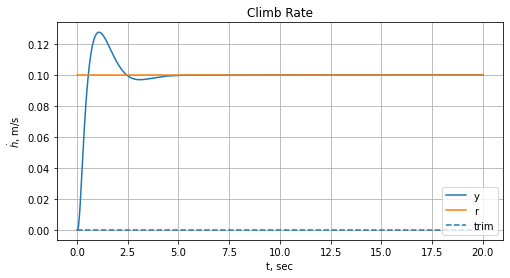

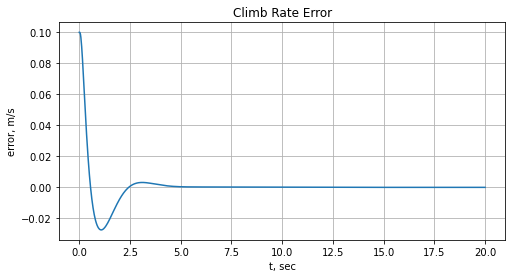

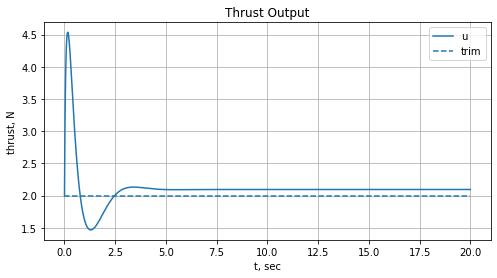

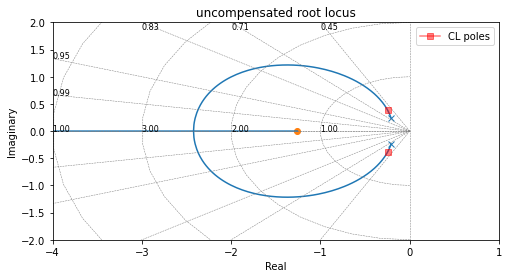

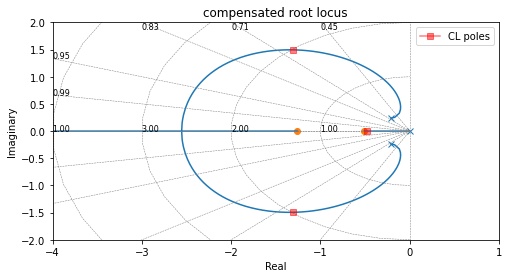

In [85]:
def thrust_to_velocity_controller_analysis(G_aircraft):
    print('thrust -> climb rate')
    t = np.linspace(0, 20, 1000)
    tol = 1e-2
    s = control.tf([1, 0], [1])
    G_a = 1/(s/10 + 1) # actuator, first order plant representing electric motor
    G = G_aircraft[4, 0]*G_a  # plant, Q due to d_e * Servo transfer function
    lowpass = 1/(s/30 + 1)
    H = 30 + 15/s + 1*s*lowpass  # PID controller with low pass filter
    G_o = G*H  # open loop
    G_c = control.feedback(G_o) # closed loop
    print('closed loop poles: ', control.pole(G_c))

    r = 0.1*np.ones(len(t))
    res = control.forced_response(G_c, T=t, U=r);
    y = res.y[0, :]

    Kv = np.real(control.minreal(s*G_o)(0))
    print('Kv', Kv)

    print('ess', 1/Kv)
    print('G:')
    print(G)

    print('G_c:')
    print(G_c)
    plt.rcParams['figure.figsize'] = (8, 4)

    plt.figure()
    plt.plot(t, y, label='y') # don't forget these are deviations from trim
    plt.plot(t, r, label='r') # don't forget these are deviations from trim
    plt.hlines(0, t[0], t[-1], linestyles='--', label='trim')
    plt.legend()
    plt.grid()
    plt.xlabel('t, sec')
    plt.ylabel('$\dot{h}$, m/s')
    plt.title('Climb Rate')

    plt.figure()
    e = r - y
    plt.plot(t, e)
    plt.grid()
    plt.xlabel('t, sec')
    plt.ylabel('error, m/s')
    plt.title('Climb Rate Error')

    plt.figure()
    res = control.forced_response(H*G_a, U=e, T=t);
    u = res.y[0, :]

    plt.plot(t, u + trim[th], label='u')  # don't forget these are deviations from trim
    plt.hlines(trim[th], t[0], t[-1], linestyles='--', label='trim')
    plt.legend()
    plt.grid()
    plt.xlabel('t, sec')
    plt.ylabel('thrust, N')
    plt.title('Thrust Output')

    plt.figure()
    control.rlocus(G, xlim=[-4, 1], ylim=[-2, 2])
    rvect, kvect = control.rlocus(G, kvect=[1], plot=False)
    h = plt.plot(np.real(rvect), np.imag(rvect),  marker='s', color='r', alpha=0.5)
    plt.legend([h[0]], ['CL poles'])
    plt.title('uncompensated root locus')

    plt.figure()
    control.rlocus(G*H, xlim=[-4, 1], ylim=[-2, 2])
    rvect, kvect = control.rlocus(G*H, kvect=[1], plot=False)
    h = plt.plot(np.real(rvect), np.imag(rvect),  marker='s', color='r', alpha=0.5)
    plt.legend([h[0]], ['CL poles'])
    plt.title('compensated root locus')
    return locals()
    
data = thrust_to_velocity_controller_analysis(G_aircraft)

In [223]:
G = G_aircraft[2, 1]
G

TransferFunction(array([-3.15312118e-17,  1.11324574e+02,  3.72658886e+01]), array([  1.        ,  24.6995594 , 127.90711277,  51.52383827,
        11.81334697]))

In [86]:
f

Matrix([
[(-C_D0*S*rho*V(t)**2/2 - C_L0**2*S*k_CLCD*rho*V(t)**2/2 - C_L0*C_La*S*k_CLCD*rho*V(t)**2*alpha(t) - C_La**2*S*k_CLCD*rho*V(t)**2*alpha(t)**2/2 - g*m*sin(gamma(t)) + th*cos(alpha(t)))/m],
[                                                                                 (-S*rho*(C_L0 + C_La*alpha(t))*V(t)**2/2 + g*m*cos(gamma(t)) + m*Q(t)*V(t) + th*sin(alpha(t)))/(m*V(t))],
[                                                                                                (S*rho*(C_L0 + C_La*alpha(t))*V(t)**2/2 - g*m*cos(gamma(t)) - th*sin(alpha(t)))/(m*V(t))],
[                                                                                                                     S*rho*(C_M0 + C_MQ*Q(t) + C_Ma*alpha(t) + C_Me*elv)*V(t)**2/(2*J_y)]])